In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
import networkx as nx
import copy

In [2]:
qubit_number = 5
qubits = range(qubit_number)

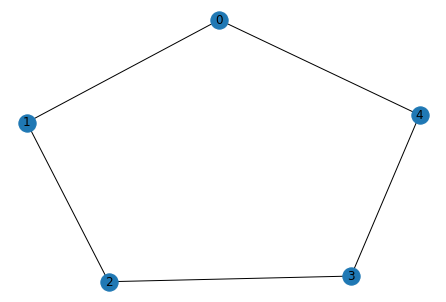

In [3]:
ising_graph=nx.cycle_graph(qubit_number)
nx.draw(ising_graph,with_labels=True)

In [4]:
print("edges",ising_graph.edges)
print("nodes",ising_graph.nodes)
Nodes=np.array(ising_graph.nodes)
Nodes

edges [(0, 1), (0, 4), (1, 2), (2, 3), (3, 4)]
nodes [0, 1, 2, 3, 4]


array([0, 1, 2, 3, 4])

In [5]:
A=np.array(nx.adjacency_matrix(ising_graph).todense())
print(A)

[[0 1 0 0 1]
 [1 0 1 0 0]
 [0 1 0 1 0]
 [0 0 1 0 1]
 [1 0 0 1 0]]


In [6]:
def Hamiltonian_matrix(edge_weights, node_weights,n_qubits,graph):
    
    # edge_weights= $\theta_1$ parameters for interaction terms
    # node_weights= $\theta_2$ parameters for single qubit terms
    
    # defining a null matrix of dimension 2^n x 2^n
    ham_matix=np.zeros((2**n_qubits,2**n_qubits))
    
    # creating the two qubit interation terms:
    for i, edge in enumerate(graph.edges):
        
        zz_interaction=1
        
        for qubit in range(n_qubits):
            
            if qubit in edge:
                
                # for only ZZ interaction but it can be generalized to XX/YY interaction
                zz_interaction=np.kron(zz_interaction,qml.PauliZ.matrix)
                
            else:
                zz_interaction=np.kron(zz_interaction,np.identity(2))
          
        ham_matix+=edge_weights[i]*zz_interaction
        
     
    # creating individual qubit energy terms:
    for i in range(n_qubits):
        
        x_term=z_term=1
        
        for j in range(n_qubits):
            
            if j==i:
                z_term=np.kron(z_term,qml.PauliZ.matrix)
                x_term=np.kron(x_term,qml.PauliX.matrix)
                
            else:
                z_term=np.kron(z_term,np.identity(2))
                x_term=np.kron(x_term,np.identity(2))
                
        ham_matix+=node_weights[i]*z_term+x_term
   
    return ham_matix

In [7]:
# Quantum data: set of training and test set of input and output quantum states

In [8]:
target_edge_weights = [0.56, 1.24, 1.67, -0.79,0.3]
target_node_weights = [-1.44, -1.43, 1.18, -0.93,-1.02]

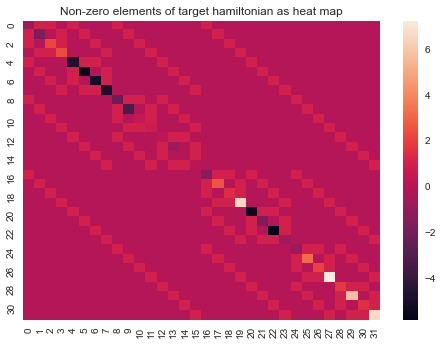

In [171]:
# Prints a visual representation of the Hamiltonian matrix
import seaborn

Ham_matrix=Hamiltonian_matrix(target_edge_weights,target_node_weights,qubit_number,ising_graph)
#plt.matshow(Ham_matrix,cmap="hot")
seaborn.heatmap(Ham_matrix)
plt.title("Non-zero elements of target hamiltonian as heat map")
plt.show()

In [48]:
np.linalg.eig(Ham_matrix)[0]

array([ 7.49938838, -7.33068966,  5.73594558,  4.74231442, -5.67401091,
        3.30718646,  2.22317568, -3.89754444, -3.26766136,  1.32309027,
        0.88494723, -0.03827101, -0.83725459, -1.04014522, -1.91133152,
       -1.71913931])

In [53]:
eigval,eigvec=np.linalg.eig(Ham_matrix)
print(eigvec[1])

[-0.09276338  0.11721782 -0.15330189  0.14135468 -0.05331957 -0.07994833
 -0.59030486 -0.02238767 -0.14453491 -0.21801228  0.53124419 -0.05169882
  0.44408153  0.1447549  -0.06179863  0.0261202 ]


In [10]:
'''
The collection of quantum data needed to run the QGRNN has two components: 

(i) copies of a low-energy state, and
(ii) a collection of time-evolved states

'''

'\nThe collection of quantum data needed to run the QGRNN has two components: \n\n(i) copies of a low-energy state, and\n(ii) a collection of time-evolved states\n\n'

In [49]:
# using VQE to find the ground state eneregy

In [11]:
coeffs = [0.56, 1.24, 1.67, -0.79, 0.3 , -1.44, -1.43, 1.18, -0.93,-1.02 ,1,1,1,1,1]
zz=[np.array([qml.PauliZ(i)@qml.PauliZ(i+1)]) for i in range(qubit_number-1)]
obs = [
    qml.PauliZ(0)@qml.PauliZ(1), qml.PauliZ(1)@qml.PauliZ(2), qml.PauliZ(2)@qml.PauliZ(3), qml.PauliZ(3)@qml.PauliZ(4),
     qml.PauliZ(4)@qml.PauliZ(0), qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3),qml.PauliZ(4), qml.PauliX(0),
    qml.PauliX(1),qml.PauliX(2),qml.PauliX(3),qml.PauliX(4)
]
H_toy = qml.vqe.Hamiltonian(coeffs, obs)
print(H_toy)

  (-1.44) [Z0]
+ (-1.43) [Z1]
+ (-1.02) [Z4]
+ (-0.93) [Z3]
+ (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1.18) [Z2]
+ (-0.79) [Z3 Z4]
+ (0.3) [Z4 Z0]
+ (0.56) [Z0 Z1]
+ (1.24) [Z1 Z2]
+ (1.67) [Z2 Z3]


In [67]:
low_energy_state=arb_state_vector=0
for i in range(1):
    low_energy_state+=(np.random.rand(32))

(low_energy_state)=low_energy_state/np.linalg.norm(low_energy_state)

In [122]:

'''
creating a random initial state which is named low_energy state but is not the lowest energy state it is just to train the 

network multiple times, and if one wish to find the ground state and wish work with that then must consider the VQE approach

to obtain ground state. But here with a random initial state we can efficiently run the circuit and simulate the exact ham but

it can be simulated exactly when the time t<1 and ~0.1-0.2 if t>0.3 then the circuit wouldn't be able to simulate.
'''

"\ncreating a random initial state which is named low_energy state but is not the lowest energy state it is just to train the \n\nnetwork multiple times, and if one wish to find the ground state and wish work with that then must consider the VQE approach\n\nto obtain ground state. But here with a random initial state we can efficiently run the circuit and simulate the exact ham but\n\nit can be simulated exactly when the time t<1 and ~0.1-0.2 if t>0.3 then the circuit wouldn't be able to simulate.\n"

In [68]:
a = np.array([1+2j,3+4j])
b = np.array([5+6j,7+8j])

print(np.dot(np.transpose(np.conj(a)),b))
# np.dot doesn't use complex conjugate of 'a'
print(np.vdot(a,b))

(70-8j)
(70-8j)


In [70]:
(np.linalg.eig(Ham_matrix)[0]) # list of eigenvalues and the min is -7.33068966

array([ 9.13032326, -8.28601312,  7.49971939, -6.98246307,  6.50486102,
       -6.22751166,  5.86980719, -5.43516146, -5.03840161, -4.76695089,
        4.51977391,  3.81144416,  3.66690216, -3.43598846, -3.17728935,
       -2.78544434,  2.94789849, -2.10978943, -1.94958533, -1.7703423 ,
        2.24227241,  2.1521784 ,  2.05329232, -1.12332523, -1.01178909,
        1.39423854,  1.14869289,  0.84802216,  0.31546239, -0.17947862,
        0.12449845,  0.05014683])

In [71]:
print(f"Minimum eigen energy:{np.real_if_close(min(np.linalg.eig(Ham_matrix)[0]))}")

Minimum eigen energy:-8.286013124483963


In [73]:
# the time evolution operator which will help to evolve the ground state

def unitary_evolution(hamiltonian,qubits,time):
    # first the hamiltonian should be created with a set of parameters then we have to call during optimization
    U=scipy.linalg.expm(-1j*hamiltonian*time)
    '''
     note that here we are calculating the exact exponentiation of hamiltonian and this is not the simulated unitary using 
     trotterizationthe, reason of doing that is to define the cost, later, as fidelity between actual evolved and simulated 
     evoled state
    '''
    qml.QubitUnitary(U,wires=qubits)

In [74]:
# defining QGRNN layer to simulate the exact exponential "unitary_evolution()" using trotterization

def QGRNN_layer(edge_weights,node_weights,graph,qubits,delta):
    '''
    here we can define the z⊗z from scratch like toffoli, fredkin case but we will directly calculate that from inbuild func.
    Parameters should be divided by n, where n=trotter steps
    '''
    # defining the layer for two qubit z⊗z interactions
    for i,edge in enumerate(graph.edges):
        qml.MultiRZ(2*edge_weights[i]*delta,wires=(edge[0],edge[1]))    # it create z⊗z interactions for all the edges
        
        # to know why the actual parameters are multiplied by 2, see the notes for qml.MultiRZ() in pennylane and see the form
        
    # defining the layer for single qubit energy
    for i,node in enumerate(graph.nodes):
        qml.RZ(2*node_weights[i]*delta,wires=node)
        qml.RX(2*delta,wires=node)

In [75]:
for edge in ising_graph.edges:
    print(edge[0],edge[1])

0 1
0 4
1 2
2 3
3 4


In [76]:
def Swap_test(control_wire,target_register1,target_register2):
    
    qml.Hadamard(wires=control_wire)
    for wire1,wire2 in zip(target_register1,target_register2):
        qml.CSWAP(wires=(control_wire,wire1,wire2))
    qml.Hadamard(wires=control_wire)


In [77]:
reg1=tuple(range(1,qubit_number+1))
reg2=tuple(range(1+qubit_number,2*qubit_number+1))
print(reg1+reg2)

control=0 # the control qubit in swap operation

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)


edges-> [(6, 7), (6, 8), (6, 9), (6, 10), (7, 8), (7, 9), (7, 10), (8, 9), (8, 10), (9, 10)]


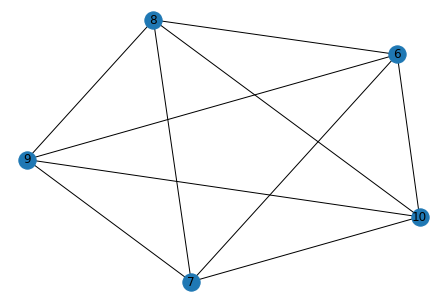

In [78]:
init_guess_ising_graph=nx.complete_graph(reg2)
nx.draw(init_guess_ising_graph,with_labels=True)
print("edges->",init_guess_ising_graph.edges)

In [79]:
qgrnn_dev = qml.device("default.qubit", wires=2 * qubit_number + 1) # 10 register qubits and 1 control qubit for swap test

In [80]:
@qml.qnode(qgrnn_dev)
def full_QGRNN_layer(edge_weights,node_weights,t):
    '''
    As mentioned in the website QGRNN consists of two register : 1. The actual set of input/output states from exp(-iHt)
    and 2. Simulated set of input/output states and finally we have to minimize the fidelity
    '''
    
    # The two input registers reg1 and reg2 will contain the same initial state i.e. the "low-energy-state".
    qml.QubitStateVector(np.kron(low_energy_state,low_energy_state),wires=reg1+reg2)
    
    unitary_evolution(Ham_matrix,reg1,t) # exp(-iHt)|ψ(0)>
    
    trotter_steps=t/delta  # see this link : 
                           # https://en.wikipedia.org/wiki/Time-evolving_block_decimation#The_Suzuki-Trotter_expansion
                           # smaller the value of delta in trotter formula -> more accurate will be the approximation
                           # according to that formula trotter step is a function of time 'T' and 'delta'
                
    for depth in range(int(trotter_steps)):
        QGRNN_layer(edge_weights,node_weights,init_guess_ising_graph,qubit_number,delta)
    
    # the wires are updated
    # applying swap test to the last 8 qubits
    Swap_test(control,reg1,reg2)
    
    return qml.expval(qml.PauliZ(control))

In [81]:
'''
@qml.qnode(qgrnn_dev)
def Swap_test1(edge_weights,node_weights,t):
    
    full_QGRNN_layer(edge_weights,node_weights,t)
    qml.Hadamard(wires=control)
    for wire1,wire2 in zip(reg1,reg2):
        qml.CSWAP(wires=(control,wire1,wire2))
    qml.Hadamard(wires=control)
    
    return qml.expval(qml.PauliZ(control))
    
'''

'\n@qml.qnode(qgrnn_dev)\ndef Swap_test1(edge_weights,node_weights,t):\n    \n    full_QGRNN_layer(edge_weights,node_weights,t)\n    qml.Hadamard(wires=control)\n    for wire1,wire2 in zip(reg1,reg2):\n        qml.CSWAP(wires=(control,wire1,wire2))\n    qml.Hadamard(wires=control)\n    \n    return qml.expval(qml.PauliZ(control))\n    \n'

In [82]:
times_sampled = np.random.rand(15)

In [83]:
times_sampled

array([0.87843943, 0.75672063, 0.78509746, 0.90120519, 0.12816194,
       0.40032992, 0.69392142, 0.6434705 , 0.44971481, 0.95521466,
       0.22252691, 0.87746819, 0.04750676, 0.67191042, 0.91109117])

In [101]:
N = 10  # The number of pieces of quantum data that are used for each step
max_time = .1  # The maximum value of time that can be used for quantum data

In [102]:
#rng = np.random.default_rng(seed=42)

def cost_function(weight_params, bias_params):

    # Randomly samples times at which the QGRNN runs
    times_sampled =np.random.rand(N)*max_time

    # Cycles through each of the sampled times and calculates the cost
    total_cost = 0
    for dt in times_sampled:
        result = full_QGRNN_layer(weight_params, bias_params,dt)
        total_cost += -1 * result

    return total_cost / N

In [103]:




weights = (np.random.rand(len(init_guess_ising_graph.edges))-0.5)
bias = (np.random.rand(qubit_number)-0.5)

initial_weights = copy.copy(weights)
initial_bias = copy.copy(bias)

In [107]:
delta=0.01 # this delta should be choosen very carefully for better guess, check the ans for a dry run of the cost below

In [108]:
cost_function(weights, bias)

tensor(-0.97174506, requires_grad=True)

In [109]:
costarr=[]
params_edge=[]
params_node=[]

In [110]:
steps = 100

In [111]:
optimizer = qml.AdamOptimizer(stepsize=0.5)

for i in range(0, steps+1):
    (weights, bias), cost = optimizer.step_and_cost(cost_function, weights, bias)

    # Prints the value of the cost function
    if i % 10 == 0:
        print(f"Cost at Step {i}: {cost}")
        costarr.append(cost)
        params_edge.append(weights)
        params_node.append(bias)
        #print(f"Weights at Step {i}: {weights}")
        #print(f"Bias at Step {i}: {bias}")
        #print("---------------------------------------------")

Cost at Step 0: -0.9713764662503074
Cost at Step 10: -0.9906002116415615
Cost at Step 20: -0.9966797732312557
Cost at Step 30: -0.9982768864654805
Cost at Step 40: -0.9980986777598749
Cost at Step 50: -0.9993903177181565
Cost at Step 60: -0.9995025256330115
Cost at Step 70: -0.9993949936501446
Cost at Step 80: -0.9994074541938186
Cost at Step 90: -0.9996175096015077
Cost at Step 100: -0.999631984628939


In [ ]:
# above can be considered as best as the fidelity is above 0.99 for t~1

In [322]:
weights_test=np.array([5.75810409e-01,  4.17373794e-02 , 1.33385607e+00  ,1.80469466e+00,
 -1.37560830e-03, -8.39439431e-01])
bias_test=np.array([-1.34861394 ,-1.31269908 , 0.97854738, -1.05489467])

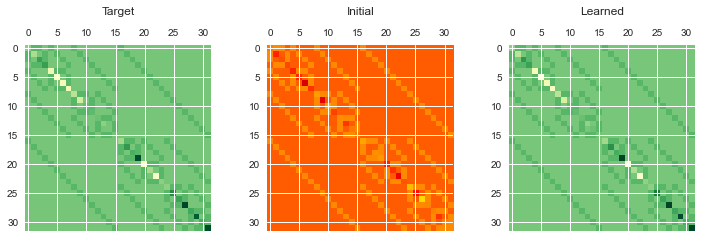

In [141]:
new_ham_matrix = Hamiltonian_matrix(weights, bias, 
    qubit_number, nx.complete_graph(qubit_number),  

)

init_ham = Hamiltonian_matrix( initial_weights, initial_bias, qubit_number, nx.complete_graph(qubit_number) 
   
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))

axes[0].matshow(Ham_matrix, vmin=-7, vmax=7, cmap="YlGn")
axes[0].set_title("Target", y=1.13)

axes[1].matshow(init_ham, vmin=-7, vmax=7, cmap="hot")
axes[1].set_title("Initial", y=1.13)

axes[2].matshow(new_ham_matrix, vmin=-7, vmax=7, cmap="YlGn")
axes[2].set_title("Learned", y=1.13)

plt.subplots_adjust(wspace=0.3, hspace=0.3)


plt.show()

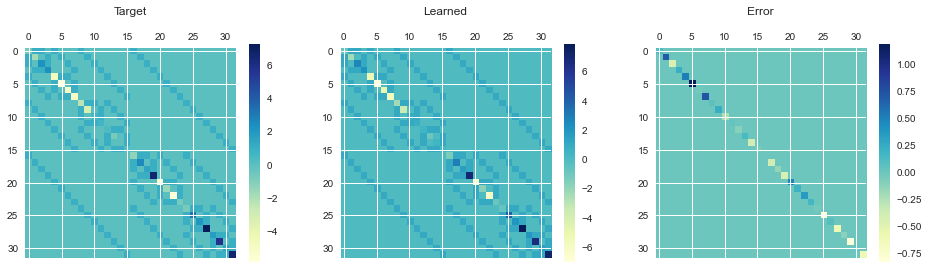

In [170]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

ax1, ax2 ,ax3 = axes

im1 = ax1.matshow(Ham_matrix,cmap="YlGnBu")
ax1.set_title("Target", y=1.13)

im2 = ax2.matshow(new_ham_matrix,cmap="YlGnBu")
ax2.set_title("Learned", y=1.13)

diff_matrix= Ham_matrix-new_ham_matrix

im3 = ax3.matshow(diff_matrix,cmap="YlGnBu")
ax3.set_title("Error", y=1.13)


fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

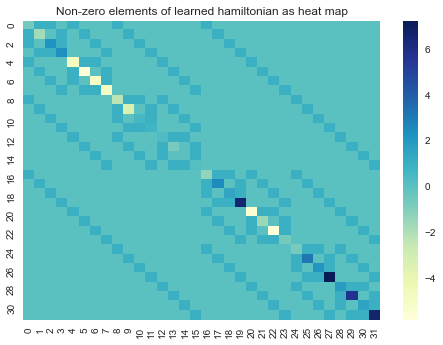

In [172]:
seaborn.heatmap(Ham_matrix,cmap="YlGnBu")
plt.title("Non-zero elements of learned hamiltonian as heat map")
plt.show()

In [116]:
# Function to find the fidelity between two unitaries
def Fidelity(rho1,rho2):
    if rho1.shape!=rho2.shape:
        raise ValueError("Dimension of both matrices must be same")
    return (np.abs(np.trace(np.dot(np.transpose(np.conj(rho1)),rho2)))/len(rho1))

In [121]:
t=0.1
rho1=scipy.linalg.expm(-1j*new_ham_matrix*t)
rho2=scipy.linalg.expm(-1j*Ham_matrix*t)
print("Fidelity between the actual and the optimized one at time 0.1 is :",Fidelity(rho2,(rho1)))

Fidelity between the actual and the optimized one at time 0.1 is : 0.9990398028421635


In [124]:
print("learned weights",weights)
print("target weights",target_edge_weights)
print("learned bias",bias)
print("target bias",target_node_weights)

learned weights [ 0.55617701 -0.01991721 -0.10338552  1.48123268  1.81443779 -0.06546915
  0.10523138 -0.79284831 -0.01948888  0.27529658]
target weights [0.56, 1.24, 1.67, -0.79, 0.3]
learned bias [-1.60745    -1.63100027  1.28495068 -1.01431646 -1.02707468]
target bias [-1.44, -1.43, 1.18, -0.93, -1.02]


In [125]:
'''
even though the learned weights and biases are slightly different this should lead to a lower fidelity but we have a very good
fidelity just because we are calculating the fidelity at t=0.1 if set t=1 then the cirucit wouldn't be able to learn 
these parameters. Thus this QGRNN approach can only provide good results when we simulate the dynamics for a small time.
'''

"\neven though the learned weights and biases are slightly different this should lead to a lower fidelity but we have a very good\nfidelity just because we are calculating the fidelity at t=0.1 if set t=1 then the cirucit wouldn't be able to learn \nthese parameters. Thus this QGRNN approach can only provide good results when we simulate the dynamics for a small time.\n"

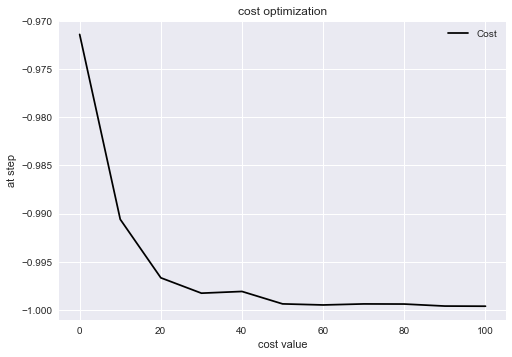

In [126]:
plt.style.use("seaborn")
plt.plot(np.linspace(0,100,11),costarr,"black",label="Cost")
plt.xlabel("cost value")
plt.ylabel("at step")
plt.title("cost optimization")
plt.legend()
plt.show()

In [173]:
new_ham_matrix

tensor([[-0.76362435,  1.        ,  1.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        , -2.39401852,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 1.        ,  0.        ,  2.63782138, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  6.570337  ,
          0.        ,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          1.48746422,  1.        ],
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  7.22615711]], requires_grad=True)

In [174]:
Ham_matrix

array([[-0.66,  1.  ,  1.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  , -1.7 ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 1.  ,  0.  ,  2.18, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ...,  5.74,  0.  ,  1.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.5 ,  1.  ],
       [ 0.  ,  0.  ,  0.  , ...,  1.  ,  1.  ,  6.62]])

In [175]:
Ham_matrix-new_ham_matrix # difference between target and learned hamiltonian

tensor([[ 0.10362435,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.69401852,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.45782138, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.830337  ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.01253578,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -0.60615711]], requires_grad=True)

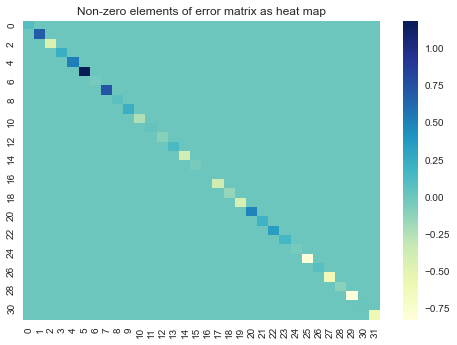

In [177]:
seaborn.heatmap(Ham_matrix-new_ham_matrix,cmap="YlGnBu")
plt.title("Non-zero elements of error matrix as heat map")
plt.show()